In [56]:
# 最正式的用法当然是研究下event_utils根目录下几个py文件并改变参数来使用
# 但这种做法有一定的局限性
# 这个代码是我写的一个demo，演示如何把别人的事件相机可视化代码中拿出来一些可用的部分，单独提取出来用在自己的数据上
# 有了anaconda的环境基本没什么要装的了，可能仍然需要稍微安装几个包，就够了
import numpy as np

import os
from event_utils.lib.visualization.draw_event_stream import plot_voxel_grid
import matplotlib.pyplot as plt
%matplotlib inline
# 要可视化event文件的path。这里需要改成自己的文件路径。
path = r"D:\event\Town01\sequence_0\events\data\01_000_0005_events.npz"

In [57]:
# 读取我们自己的event文件
# 看看npz文件夹内容
events = np.load(path)
events.files

['x', 'y', 'p', 't']

In [63]:
# 看看shape和最大值，可以用来确定分辨率
xs = events['x']
print(xs.shape)
print(xs.max())

(33005,)
511


In [59]:
# 这里就不多看了，感兴趣的同学自己探索下内容和shape
ys = events['y']
ps = events['p']
ts = events['t']

In [60]:
# 这部分是把下面拆出来的代码的需要调用的其他函数一并拿过来了。
# 如果选择直接import xxxx的形式，就不需要这些定义。
def ensure_dir(file_path):
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        print(f"Creating {directory}")
        os.makedirs(directory)

def events_to_image(xs, ys, ps, sensor_size=(180, 240), interpolation=None, padding=False, meanval=False, default=0):
    """
    Place events into an image using numpy
    @param xs x coords of events
    @param ys y coords of events
    @param ps Event polarities/weights
    @param sensor_size The size of the event camera sensor
    @param interpolation Whether to add the events to the pixels by interpolation (values: None, 'bilinear')
    @param padding If true, pad the output image to include events otherwise warped off sensor
    @param meanval If true, divide the sum of the values by the number of events at that location
    @returns Event image from the input events
    """
    img_size = (sensor_size[0]+1, sensor_size[1]+1)
    if interpolation == 'bilinear' and xs.dtype is not torch.long and xs.dtype is not torch.long:
        xt, yt, pt = torch.from_numpy(xs), torch.from_numpy(ys), torch.from_numpy(ps)
        xt, yt, pt = xt.float(), yt.float(), pt.float()
        img = events_to_image_torch(xt, yt, pt, clip_out_of_range=True, interpolation='bilinear', padding=padding)
        img[img==0] = default
        img = img.numpy()
        if meanval:
            event_count_image = events_to_image_torch(xt, yt, torch.ones_like(xt),
                    clip_out_of_range=True, padding=padding)
            event_count_image = event_count_image.numpy()
    else:
        coords = np.stack((ys, xs))
        try:
            abs_coords = np.ravel_multi_index(coords, img_size)
        except ValueError:
            print("Issue with input arrays! minx={}, maxx={}, miny={}, maxy={}, coords.shape={}, \
                    sum(coords)={}, sensor_size={}".format(np.min(xs), np.max(xs), np.min(ys), np.max(ys),
                        coords.shape, np.sum(coords), img_size))
            raise ValueError
        img = np.bincount(abs_coords, weights=ps, minlength=img_size[0]*img_size[1])
        img = img.reshape(img_size)
        if meanval:
            event_count_image = np.bincount(abs_coords, weights=np.ones_like(xs), minlength=img_size[0]*img_size[1])
            event_count_image = event_count_image.reshape(img_size)
    if meanval:
        img = np.divide(img, event_count_image, out=np.ones_like(img)*default, where=event_count_image!=0)
    return img[0:sensor_size[0], 0:sensor_size[1]]


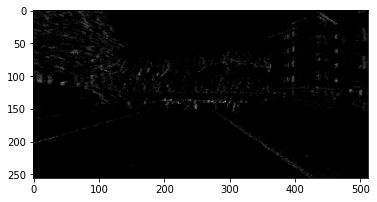

In [61]:
# 核心部分。
# 代码来源：event_utils\lib\visualization\visualizers.py 里面的EventImageVisualizer。
# 对比就会发现，我只是稍微做了一点改动。
# 最重要的是 1.提供了sensor_size信息（在我们的数据上是512x256，这个是需要我们提供的） 2.使用我们的数据直接提供了xs,ys,ts,ps
save_path=r"D:\event\vis"
sensor_size = (256,512)


img = events_to_image(xs.astype(int), ys.astype(int), ps, sensor_size, interpolation=None, padding=False)
mn, mx = np.min(img), np.max(img)
img = (img-mn)/(mx-mn)

fig = plt.figure()
plt.imshow(img, cmap='gray')
ensure_dir(save_path)
plt.savefig(save_path, transparent=True, dpi=600, bbox_inches = 'tight')